In [1]:
import open3d as o3d
import numpy as np
import os
import sys

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

# RGBD Odometry
An RGBD odometry finds the camera movement between two consecutive RGBD image pairs. The input are two instances of `RGBDImage`. The output is the motion in the form of a rigid body transformation. Open3D implements the method of [\[Steinbrucker2011\]](../reference.html#steinbrucker2011) and [\[Park2017\]](../reference.html#park2017).

## Read camera intrinsic
We first read the camera intrinsic matrix from a `json` file.

In [2]:
pinhole_camera_intrinsic = o3d.io.read_pinhole_camera_intrinsic(
    o3dtut.get_data_path_common("camera_primesense.json"))
print(pinhole_camera_intrinsic.intrinsic_matrix)

[[525.    0.  319.5]
 [  0.  525.  239.5]
 [  0.    0.    1. ]]


<div class="alert alert-info">
    
**Note:** 

Lots of small data structures in Open3D can be read from / written into `json` files. This includes camera intrinsics, camera trajectory, pose graph, etc.

</div>

## Read RGBD image
This code block reads two pairs of RGBD images in the Redwood format. We refer to [Redwood dataset](rgbd_image.ipynb#Redwood-dataset) for a comprehensive explanation.

In [3]:
source_color = o3d.io.read_image(
    o3dtut.get_data_path_common("RGBD/color/00000.jpg"))
source_depth = o3d.io.read_image(
    o3dtut.get_data_path_common("RGBD/depth/00000.png"))
target_color = o3d.io.read_image(
    o3dtut.get_data_path_common("RGBD/color/00001.jpg"))
target_depth = o3d.io.read_image(
    o3dtut.get_data_path_common("RGBD/depth/00001.png"))
source_rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    source_color, source_depth)
target_rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    target_color, target_depth)
target_pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    target_rgbd_image, pinhole_camera_intrinsic)

<div class="alert alert-info">
    
**Note:** 

Open3D assumes the color image and depth image are synchronized and registered in the same coordinate frame. This can usually be done by turning on both the synchronization and registration features in the RGBD camera settings.

</div>

## Compute odometry from two RGBD image pairs

In [4]:
option = o3d.pipelines.odometry.OdometryOption()
odo_init = np.identity(4)
print(option)

[success_color_term, trans_color_term,
 info] = o3d.pipelines.odometry.compute_rgbd_odometry(
     source_rgbd_image, target_rgbd_image, pinhole_camera_intrinsic, odo_init,
     o3d.pipelines.odometry.RGBDOdometryJacobianFromColorTerm(), option)
[success_hybrid_term, trans_hybrid_term,
 info] = o3d.pipelines.odometry.compute_rgbd_odometry(
     source_rgbd_image, target_rgbd_image, pinhole_camera_intrinsic, odo_init,
     o3d.pipelines.odometry.RGBDOdometryJacobianFromHybridTerm(), option)

OdometryOption class.
iteration_number_per_pyramid_level = [ 20, 10, 5, ] 
max_depth_diff = 0.030000
min_depth = 0.000000
max_depth = 4.000000


This code block calls two different RGBD odometry methods. The first one is from [\[Steinbrucker2011\]](../reference.html#steinbrucker2011). It minimizes photo consistency of aligned images. The second one is from [\[Park2017\]](../reference.html#park2017). In addition to photo consistency, it implements constraint for geometry. Both functions run in similar speed, but [\[Park2017\]](../reference.html#park2017) is more accurate in our test on benchmark datasets and is thus the recommended method.

Several parameters in `OdometryOption()`:

- `minimum_correspondence_ratio`: After alignment, measure the overlapping ratio of two RGBD images. If overlapping region of two RGBD image is smaller than specified ratio, the odometry module regards that this is a failure case.
- `max_depth_diff`: In depth image domain, if two aligned pixels have a depth difference less than specified value, they are considered as a correspondence. Larger value induce more aggressive search, but it is prone to unstable result.
- `min_depth` and `max_depth`: Pixels that has smaller or larger than specified depth values are ignored.

## Visualize RGBD image pairs
The RGBD image pairs are converted into point clouds and rendered together. Note that the point cloud representing the first (source) RGBD image is transformed with the transformation estimated by the odometry. After this transformation, both point clouds are aligned.

Using RGB-D Odometry
[[ 9.99988286e-01 -7.53983409e-05 -4.83963172e-03  2.74054550e-04]
 [ 1.83909052e-05  9.99930634e-01 -1.17782559e-02  2.29634918e-02]
 [ 4.84018408e-03  1.17780289e-02  9.99918922e-01  6.02121265e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


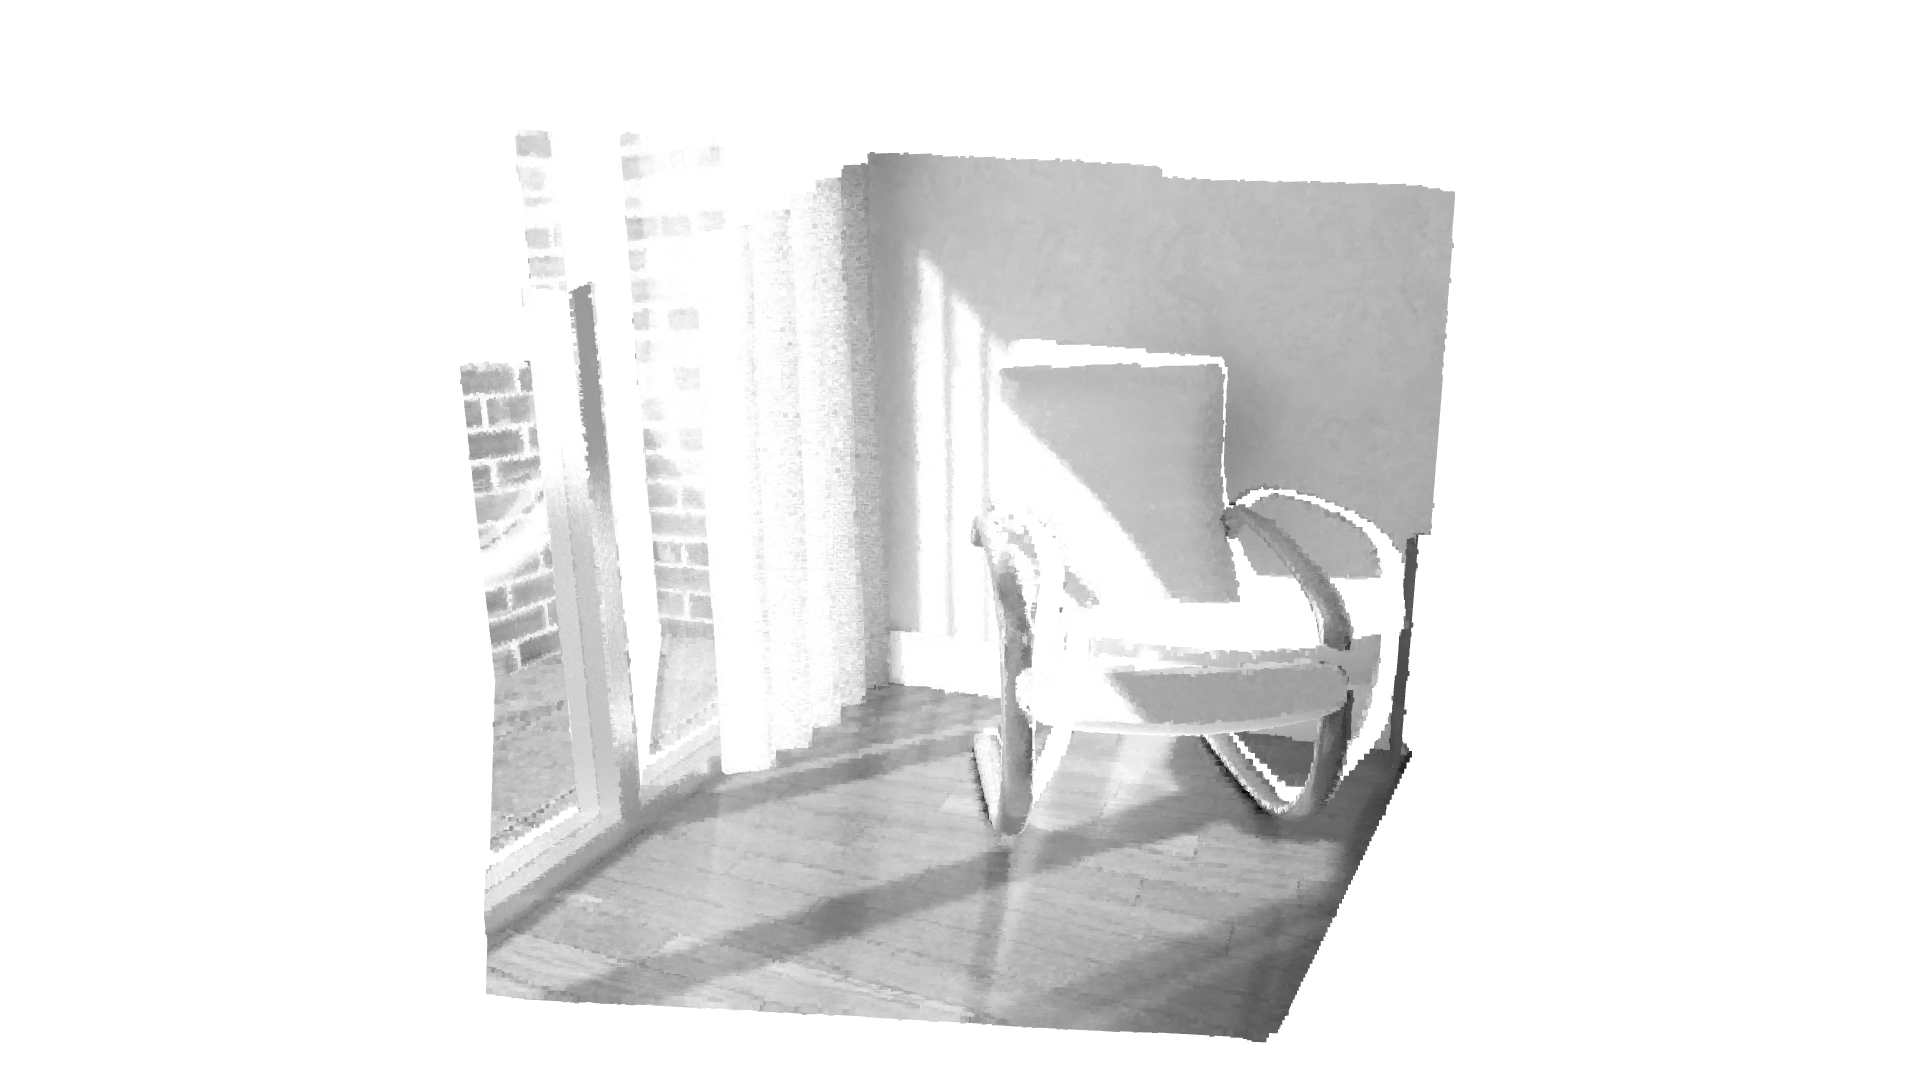

Using Hybrid RGB-D Odometry
[[ 9.99992973e-01 -2.51084541e-04 -3.74035273e-03 -1.07049775e-03]
 [ 2.07046059e-04  9.99930714e-01 -1.17696227e-02  2.32280983e-02]
 [ 3.74304875e-03  1.17687656e-02  9.99923740e-01  1.40592054e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


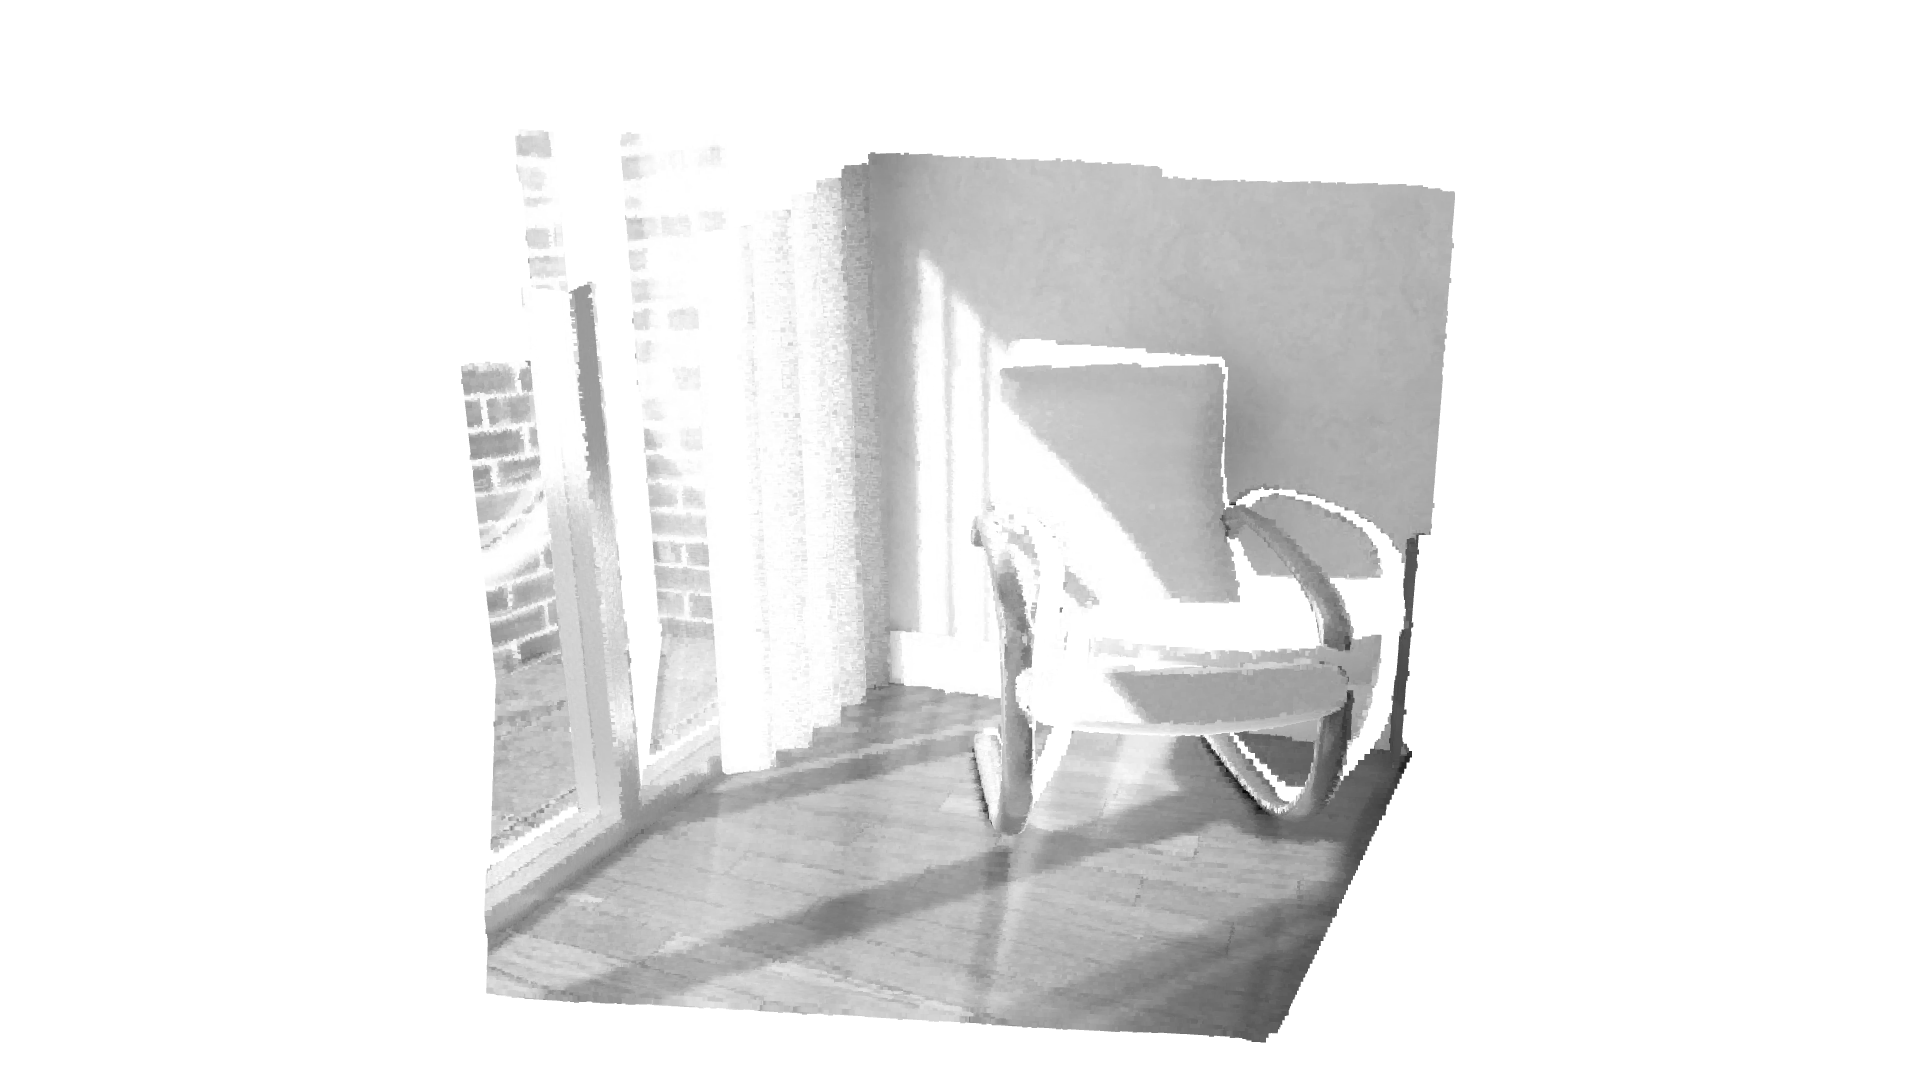

In [5]:
if success_color_term:
    print("Using RGB-D Odometry")
    print(trans_color_term)
    source_pcd_color_term = o3d.geometry.PointCloud.create_from_rgbd_image(
        source_rgbd_image, pinhole_camera_intrinsic)
    source_pcd_color_term.transform(trans_color_term)
    o3d.visualization.draw_geometries([target_pcd, source_pcd_color_term],
                                      zoom=0.48,
                                      front=[0.0999, -0.1787, -0.9788],
                                      lookat=[0.0345, -0.0937, 1.8033],
                                      up=[-0.0067, -0.9838, 0.1790])
if success_hybrid_term:
    print("Using Hybrid RGB-D Odometry")
    print(trans_hybrid_term)
    source_pcd_hybrid_term = o3d.geometry.PointCloud.create_from_rgbd_image(
        source_rgbd_image, pinhole_camera_intrinsic)
    source_pcd_hybrid_term.transform(trans_hybrid_term)
    o3d.visualization.draw_geometries([target_pcd, source_pcd_hybrid_term],
                                      zoom=0.48,
                                      front=[0.0999, -0.1787, -0.9788],
                                      lookat=[0.0345, -0.0937, 1.8033],
                                      up=[-0.0067, -0.9838, 0.1790])